![HSV-AI Logo](https://github.com/HSV-AI/hugo-website/blob/master/static/images/logo_v9.png?raw=true)

# Implicit Recommendation from ECommerce Data

Some of the material for this work is based on [A Gentle Introduction to Recommender Systems with Implicit Feedback](https://jessesw.com/Rec-System/) by Jesse Steinweg Woods. This tutorial includes an implementation of the Alternating Least Squares algorithm and some other useful functions (like the area under the curve calculation). Other parts of the tutorial are based on a previous version of the Implicit library and had to be reworked.

The dataset used for this work is from Kaggle [Vipin Kumar Transaction Data](https://www.kaggle.com/vipin20/transaction-data):

## Context

This is a item purchased transactions data. It has 8 columns.
This data makes you familer with transactions data.

## Content

Data description is :-

* UserId -It is a unique ID for all User Id
* TransactionId -It contains unique Transactions ID
* TransactionTime -It contains Transaction Time
* ItemCode -It contains item code that item will be purchased
* ItemDescription -It contains Item description
* NumberOfItemPurchased -It contains total number of items Purchased
* CostPerltem -Cost per item Purchased
* Country -Country where item purchased


# Global Imports

In [2]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import implicit
import scipy
from sklearn import metrics
from pandas.api.types import CategoricalDtype

# Implicit Recommendation Model

The code below creates and trains one of the models available from the Implicit package. Currently using hyperparameters suggested by various tutorials with no tuning.

In [3]:
alpha = 29
factors = 64
regularization = 0.117
iterations = 73

model = implicit.als.AlternatingLeastSquares(factors=factors,
                                    regularization=regularization,
                                    iterations=iterations)

user_vecs = np.load('../data/interim/user_factors.npy')
item_vecs = np.load('../data/interim/item_factors.npy')

model.user_factors = user_vecs
model.item_factors = item_vecs

# Load data and test

Unique invoices 25900
Unique products 4070
Total rows 541909
There are 4070 unique products

Here are the counts of products ordered from largest to smallest
[2313 2203 2159 ...    1    1    1]

And a graph of what the curve looks like:


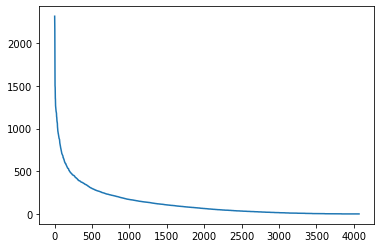

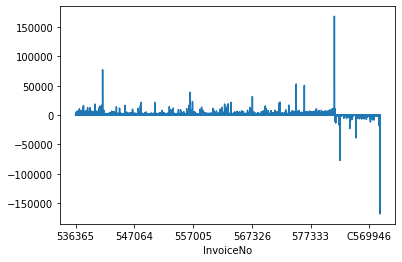

There are 10624 negative quantities
There are 2 negative unit prices
19960
7113
number of orders: 19960, number of items: 4070
matrix sparsity: 0.993475
Orders with at least 2 products: 18334
Orders with less than 2 products: 1626
Original dataframe length: 530104
Filtered dataframe length: 72875
There are 3388 unique products


And a graph of what the curve looks like:


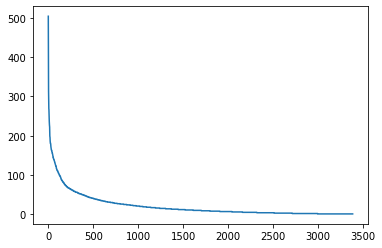

number of orders: 5761, number of items: 3388
matrix sparsity: 0.972841
<class 'pandas.core.frame.DataFrame'>
Int64Index: 72875 entries, 0 to 541893
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   InvoiceNo  72875 non-null  object
 1   StockCode  72875 non-null  object
 2   Quantity   72875 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


In [4]:
%run ./ECommerce-Implicit-EDA.ipynb

In [5]:
def make_train(ratings, pct_test = 0.2):
    '''
    This function will take in the original user-item matrix and "mask" a percentage of the original ratings where a
    user-item interaction has taken place for use as a test set. The test set will contain all of the original ratings, 
    while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 
    
    parameters: 
    
    ratings - the original ratings matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    pct_test - The percentage of user-item interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original ratings. 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the user-item pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected user-item indices, which user rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(0) # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user rows that were altered  


In [6]:
product_train, product_test, product_users_altered = make_train(purchases_sparse, pct_test = 0.1)

# Scoring the Model

Following the tutorial, we will use the area under the Receiver Operating Characteristic curve. 

In [7]:
def auc_score(predictions, test):
    '''
    This simple function will output the area under the curve using sklearn's metrics. 
    
    parameters:
    
    - predictions: your prediction output
    
    - test: the actual target result you are comparing to
    
    returns:
    
    - AUC (area under the Receiver Operating Characterisic curve)
    '''
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)   


In [8]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    This function will calculate the mean AUC by user for any user that had their user-item matrix altered. 
    
    parameters:
    
    training_set - The training set resulting from make_train, where a certain percentage of the original
    user/item interactions are reset to zero to hide them from the model 
    
    predictions - The matrix of your predicted ratings for each user/item pair as output from the implicit MF.
    These should be stored in a list, with user vectors as item zero and item vectors as item one. 
    
    altered_users - The indices of the users where at least one user/item pair was altered from make_train function
    
    test_set - The test set constucted earlier from make_train function
    
    
    
    returns:
    
    The mean AUC (area under the Receiver Operator Characteristic curve) of the test set only on user-item interactions
    there were originally zero to test ranking ability in addition to the most popular items as a benchmark.
    '''
    
    
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark


In [9]:
test, popular = calc_mean_auc(product_train, product_users_altered, 
              [scipy.sparse.csr_matrix(item_vecs), scipy.sparse.csr_matrix(user_vecs.T)], product_test)

print('Our model scored',test,'versus a score of',popular,'if we always recommended the most popular item.')

Our model scored 0.801 versus a score of 0.737 if we always recommended the most popular item.


# Spot Checking

Now that we have a pretty good idea of the model performance overall, we can spot check a few things like finding similar items and checking item recommendations for an existing invoice.

In [10]:
related = model.similar_items(1284)
for rel in related:
    index = rel[0]
    prob = rel[1]
    item = item_lookup[item_lookup.StockCode == products[index]].values
    print(prob, item[0][1])

1.0000001 SKULLS PARTY BAG + STICKER SET
0.71416897 DINOSAUR PARTY BAG + STICKER SET
0.6889714 PACK OF 6 SKULL PAPER CUPS
0.666293 RETROSPOT PARTY BAG + STICKER SET
0.6524602 3D SHEET OF DOG STICKERS
0.55458343 PACK OF 6 SKULL PAPER PLATES
0.52296937 SET OF 9 BLACK SKULL BALLOONS
0.5190454 SKULLS SQUARE TISSUE BOX
0.50416785 BLUE PARTY BAGS 
0.48836294 MILK PAN BLUE POLKADOT


In [11]:
user_items = (product_train * alpha).astype('double').T.tocsr()
def recommend(order):
    print('Order Contents:')
    print(filtered_df[filtered_df.InvoiceNo == invoices[order]].loc[:, ['InvoiceNo','StockCode', 'Description']])
    print('Recommendations:')
    recommendations = model.recommend(order, user_items)
    for rec in recommendations:
        index = rec[0]
        prob = rec[1]
        stock_code = products[index]
        item = item_lookup[item_lookup.StockCode == stock_code].values
        print(prob, stock_code, item[0][1])    

In [12]:
recommend(1)

Order Contents:
  InvoiceNo StockCode                Description
7    536366     22633     HAND WARMER UNION JACK
8    536366     22632  HAND WARMER RED POLKA DOT
Recommendations:
0.74956834 22865 HAND WARMER OWL DESIGN
0.73069584 22867 HAND WARMER BIRD DESIGN
0.72608113 22866 HAND WARMER SCOTTY DOG DESIGN
0.6818391 23439 HAND WARMER RED LOVE HEART
0.42660028 22834 HAND WARMER BABUSHKA DESIGN
0.38726404 23355 HOT WATER BOTTLE KEEP CALM
0.32752994 22114 HOT WATER BOTTLE TEA AND SYMPATHY
0.31842625 21481 FAWN BLUE HOT WATER BOTTLE
0.29915887 22111 SCOTTIE DOG HOT WATER BOTTLE
0.28261927 22306 SILVER MUG BONE CHINA TREE OF LIFE


In [14]:
invoices = selected_df.InvoiceNo.unique()

print(list(invoices).index('567893'))
recommend(4173)

4173
Order Contents:
       InvoiceNo StockCode                       Description
354726    567893     22112        CHOCOLATE HOT WATER BOTTLE
354727    567893     21485  RETROSPOT HEART HOT WATER BOTTLE
354728    567893     22113       GREY HEART HOT WATER BOTTLE
Recommendations:
0.8690075 22835 HOT WATER BOTTLE I AM SO POORLY
0.86072254 22111 SCOTTIE DOG HOT WATER BOTTLE
0.8454639 22114 HOT WATER BOTTLE TEA AND SYMPATHY
0.77937984 23355 HOT WATER BOTTLE KEEP CALM
0.6623072 23356 LOVE HOT WATER BOTTLE
0.62823534 84029E RED WOOLLY HOTTIE WHITE HEART.
0.53677493 21484 CHICK GREY HOT WATER BOTTLE
0.5278425 84030E ENGLISH ROSE HOT WATER BOTTLE
0.51009405 21479 WHITE SKULL HOT WATER BOTTLE 
0.48591456 84029G KNITTED UNION FLAG HOT WATER BOTTLE


In [15]:
recommended_price = []
for user in product_users_altered:
    recommendations = model.recommend(user, user_items)
    index = recommendations[0][0]
    price = price_lookup[price_lookup.StockCode == products[index]].values
    recommended_price.append(price[0][1])
    
total_recommended = np.sum(recommended_price)

print('After recommending',len(product_users_altered),'items, there would be an increase of',
      "${:,.2f}".format(total_recommended*test),'in additional purchases.')

After recommending 2031 items, there would be an increase of $7,352.76 in additional purchases.


In [ ]:
print(recommended_price)